# Setting things up

In [1]:
import numpy as np
import time
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV
from tqdm import tqdm
import multiprocessing as mp

random_state=42
np.random.seed(random_state)
cpu=mp.cpu_count() 
cpu

8

In [2]:
alpha=.1 #Significance level
iterations=500 #MC simulations to calculate type-1 error and power
n_vals=100 #Number of training sets
p=500 #Z dim
m=250 #Training set size
n=250 #Test set size
frac=.01

class Lasso():
    def __init__(self, random_state):
        self.random_state = random_state
    def fit(self, X, Y):
        self.model = LassoCV(cv=5, random_state=self.random_state).fit(X, Y.squeeze())
    def predict(self, X):
        return self.model.predict(X).reshape((-1,1))
    
class Ridge():
    def __init__(self):
        pass
    def fit(self, X, Y):
        self.model = RidgeCV(cv=5).fit(X, Y.squeeze())
    def predict(self, X):
        return self.model.predict(X).reshape((-1,1))
    
class MinimumNorm():
    def __init__(self):
        pass
    def fit(self, X, Y):
        self.beta = X.T@np.linalg.inv(X@X.T)@Y
    def predict(self, X):
        return X@self.beta
    
def get_pval_gcm(X, Z, Y, model_x, model_y):
    n = X.shape[0]
    rx = X-model_x.predict(Z)
    ry = Y-model_y.predict(Z)
    T = rx.squeeze()*ry.squeeze()
    pval = 2*(1 - scipy.stats.norm.cdf(abs(np.sqrt(n)*np.mean(T)/np.std(T))))
    return pval

def exp_linear_model(rs):
    
    #time.sleep(rs**.5) 
    #print("*",rs,"*")
    
    total = 3*(iterations+1)
    pvals = []

    #Generative params
    beta_x = np.vstack((20*np.ones(int(frac*p)).reshape((-1,1)), np.zeros(p-int(frac*p)).reshape((-1,1))))
    beta_y = np.vstack((np.zeros(p-int(frac*p)).reshape((-1,1)), 20*np.ones(int(frac*p)).reshape((-1,1))))

    #Training data
    Z_train_state = np.random.RandomState(total*rs)
    Z_train = Z_train_state.normal(0, 1, m*p).reshape((m,p))
    X_train_state = np.random.RandomState(total*rs+1)
    X_train = Z_train@beta_x
    X_train += X_train_state.normal(0, 1, X_train.shape)
    Y_train_state = np.random.RandomState(total*rs+2)
    Y_train = Z_train@beta_y
    Y_train += Y_train_state.normal(0, 1, Y_train.shape)

    #Models
    lasso_x = Lasso(0)
    lasso_x.fit(Z_train, X_train)
    lasso_y = Lasso(0)
    lasso_y.fit(Z_train, Y_train)
    mn_x = MinimumNorm()
    mn_x.fit(Z_train, X_train)
    mn_y = MinimumNorm()
    mn_y.fit(Z_train, Y_train)

    for it in range(iterations):
        Z_test_state = np.random.RandomState(total*rs + 3*(it+1))
        Z_test = np.random.normal(0, 1, m*p).reshape((m,p))
        X_test_state = np.random.RandomState(total*rs + 3*(it+1) + 1)
        X_test = Z_test@beta_x
        X_test += np.random.normal(0, 1, X_test.shape)
        Y_test_state = np.random.RandomState(total*rs + 3*(it+1) + 2)
        Y_test = Z_test@beta_y
        Y_test += np.random.normal(0, 1, X_test.shape)

        #Tests
        pvals.append([get_pval_gcm(X_test, Z_test, Y_test, lasso_x, lasso_y),
                      get_pval_gcm(X_test, Z_test, Y_test, mn_x, mn_y)])
    
    return pvals


In [3]:
%%time

pool = mp.Pool(cpu)
pvals = pool.map(exp_linear_model, [j for j in range(n_vals)])
pool.close()
pool.join()
pvals = np.array(pvals)

CPU times: user 372 ms, sys: 247 ms, total: 618 ms
Wall time: 5min 56s


In [4]:
error = np.mean(pvals<alpha, axis=1)

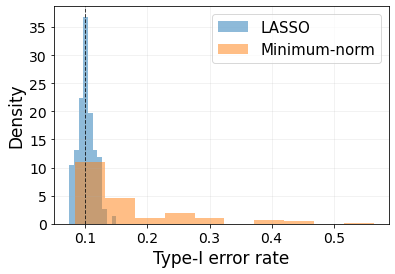

In [5]:
plt.hist(error[:,0], alpha=.5, density=True, label='LASSO')
plt.hist(error[:,1], alpha=.5, density=True, label='Minimum-norm')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Type-I error rate", size=17)
plt.ylabel("Density", size=17)
plt.axvline(x=alpha, color='black', linestyle='--', lw=1, alpha=.75)
plt.grid(alpha=.2)
plt.legend(framealpha=0.75, prop={'size': 15}, ncol=1) 
plt.savefig('plots/linear_model_exp.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()